# Sudeste Module 3 Exam

### Instructions
Modify this notebook to compose your model. You may use additional `.py` files within this folder, `src/` for composing your framework.

It is discouraged to rename the `notebook.ipynb` for this particular task.

<div style="background-color: #f7f7f7; border: 1px solid #e1e1e1; border-radius: 5px; padding: 15px; max-width: 400px;">
    <h2 style="color: #333333; font-family: Arial, sans-serif;">Submitted by Group 6</h2>
    <ul style="color: #555555; font-family: Arial, sans-serif; font-size: 16px;">
        <li>Aguaviva, Christopher</li>
        <li>Baluyot, Kent Ryan</li>
        <li>Berida, Ronabelle</li>
    </ul>
</div>


### <span style="color:Orange;">  Table of Contents: </span>

I.    [Executive Summary](#summary)

II.   [Problem Statement](#problem)

III.  [Objective](#objective)

IV.   [Data Cleaning](#datacleaning)

V.    [Visualizations and EDA](#eda)

VI.   [ARIMA Model](#arima)

VII.  [Deep Learning Model](#dl)
  
VIII. [Comparison](#comparison)

IX.   [Conclusion and Recommendations](#conclusion)

***

## <span style="color:Orange;"> I. Executive Summary </span>  <a name="summary"></a>
`edit contents`

## <span style="color:Orange;"> II. Problem Statement </span>  <a name="problem"></a>  
`edit contents`

## <span style="color:Orange;"> III. Objective </span>  <a name="objective"></a>  
`edit contents`

## <span style="color:Orange;"> IV. Data Cleaning </span>  <a name="datacleaning"></a>  

Importing Modules

In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import warnings
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import tensorflow as tf

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from datetime import datetime

pd.set_option('display.max_columns', 40)   # displays max columns of the DataFrame 

### Processing the data
In this dataset, the group opt to only take the latest 30 days in the dataset as the dataset are divided into hours instead of day. In this case, the dataset is filtered, only taking the rows that are in the month of September 2016.

In [4]:
# Chunking the dataset for faster processing of data
filepath = "C:/Users/User/Downloads/sudeste.csv"
chunk_size = 30000 
df = pd.DataFrame()

# Iterate over chunks of the file and process each chunk
for chunk in pd.read_csv(filepath, parse_dates=['mdct', 'date'], chunksize=chunk_size):
    filtered_chunk = chunk[chunk['date'] >= '2016-01-01']
    df = pd.concat([df, filtered_chunk])

In [6]:
# Only showing the columns with null values
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]  
if not missing_columns.empty:
    print('Columns with missing values:')
    print(missing_columns)
else:
    print('No missing values in any columns.')

Columns with missing values:
prcp    668060
gbrd    328121
temp        11
dewp        64
tmax        10
dmax        41
tmin         5
dmin       103
wdsp     75367
gust     25152
dtype: int64


In [7]:
# Filling missing values with the average of the previous and next non-null values
# This is done ONLY to the relevant columns

df['prcp'] = df['prcp'].fillna((df['prcp'].ffill() + df['prcp'].bfill()) / 2)
df['wdsp'] = df['wdsp'].fillna((df['wdsp'].ffill() + df['wdsp'].bfill()) / 2)
df['temp'] = df['temp'].fillna((df['temp'].ffill() + df['temp'].bfill()) / 2) 

In [8]:
# Only showing the columns with null values
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]  
if not missing_columns.empty:
    print('Columns with missing values:')
    print(missing_columns)
else:
    print('No missing values in any columns.')

Columns with missing values:
prcp      185
gbrd       10
dewp       64
tmax       10
dmax       41
tmin        5
dmin      103
gust    25152
dtype: int64


In [9]:
# Another filling of rows with null values
df['prcp'] = df['prcp'].fillna(df['prcp'].ffill())
df['prcp'] = df['prcp'].fillna(df['prcp'].bfill())

## <span style="color:Orange;"> V. Visualizations and EDA </span>  <a name="eda"></a>  

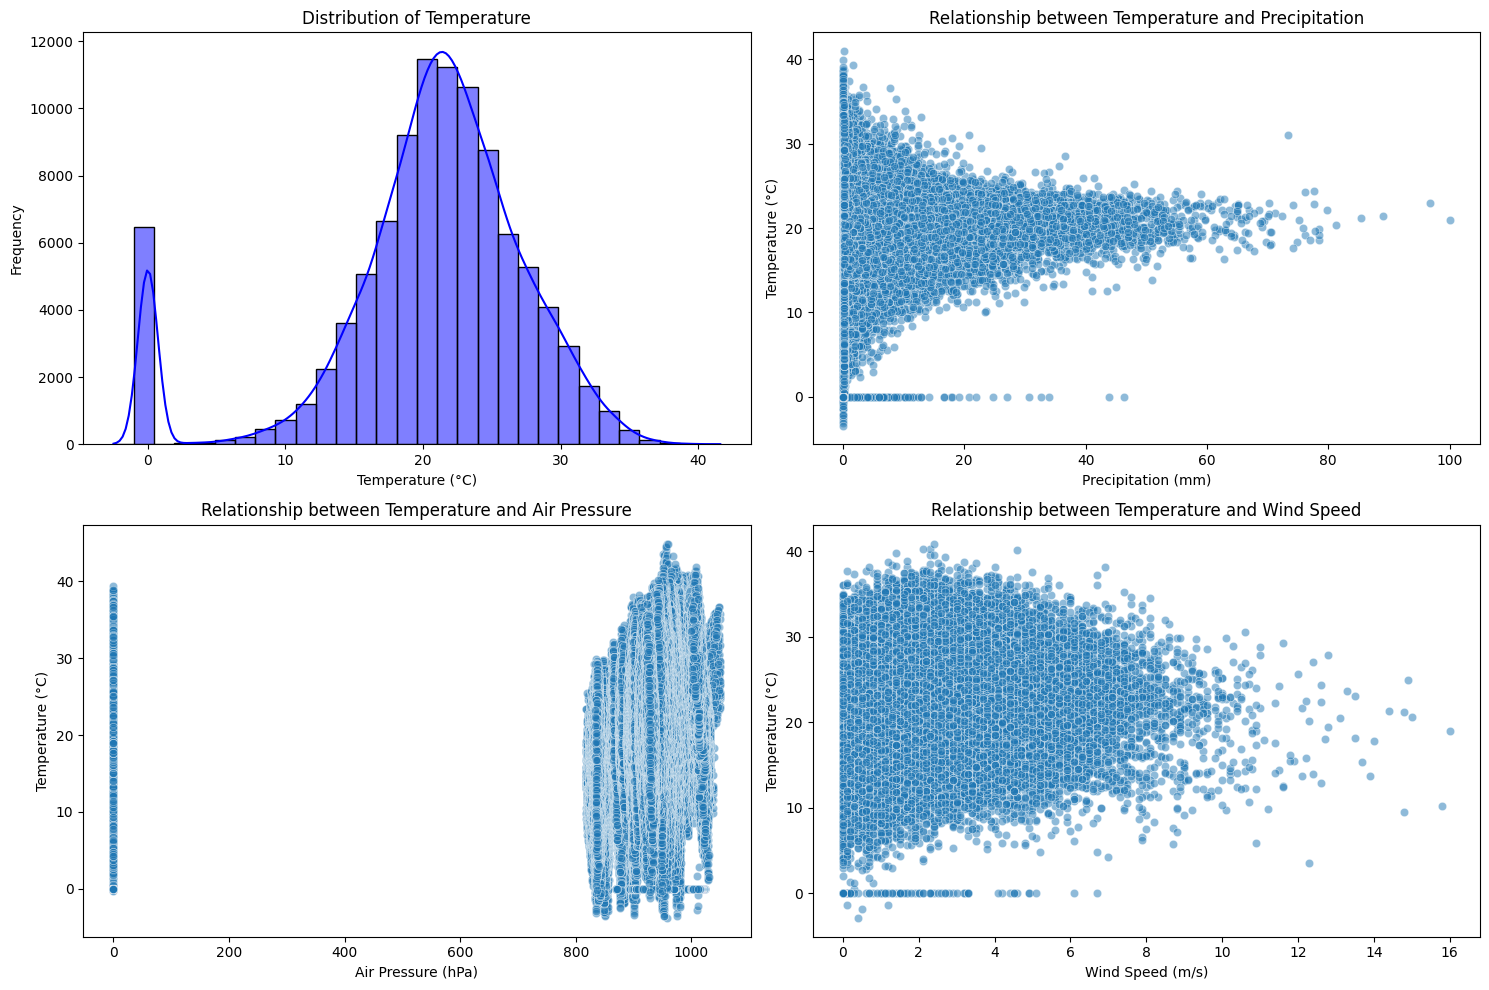

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Visualize the distribution of temperature
sns.histplot(df['temp'].sample(n=100000), bins=30, kde=True, color='blue', ax=axes[0, 0])  # Sample a subset of data for visualization
axes[0, 0].set_title('Distribution of Temperature')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('Frequency')

# Relationship between Temperature and Precipitation
sns.scatterplot(x='prcp', y='temp', data=df, alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Relationship between Temperature and Precipitation')
axes[0, 1].set_xlabel('Precipitation (mm)')
axes[0, 1].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Air Pressure
sns.scatterplot(x='stp', y='temp', data=df, alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Relationship between Temperature and Air Pressure')
axes[1, 0].set_xlabel('Air Pressure (hPa)')
axes[1, 0].set_ylabel('Temperature (°C)')

# Relationship between Temperature and Wind Speed
sns.scatterplot(x='wdsp', y='temp', data=df.sample(n=100000), alpha=0.5, ax=axes[1, 1])  # Sample a subset of data for visualization
axes[1, 1].set_title('Relationship between Temperature and Wind Speed')
axes[1, 1].set_xlabel('Wind Speed (m/s)')
axes[1, 1].set_ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

In [20]:
# List of all the weather stations/cities
df['wsnm'].unique()

array(['SÃO GONÇALO', 'VITÓRIA', 'SANTA TERESA', 'LINHARES',
       'ALFREDO CHAVES', 'SÃO MATEUS', 'ALEGRE', 'PRES. KENNEDY',
       'NOVA VENECIA', 'AFONSO CLAUDIO', 'BARBACENA', 'ARAXÁ',
       'MONTES CLAROS', 'UBERLÂNDIA', 'ALMENARA', 'MONTE VERDE', 'VIÇOSA',
       'TIMÓTEO', 'ITUIUTABA', 'OURO BRANCO', 'S.J.DEL REI', 'VARGINHA',
       'PASSOS', 'MURIAÉ', 'JUÍZ DE FORA', 'CAMPINA VERDE',
       'CONC. DAS ALAGOAS', 'BELO HOR. (PAMPULHA)', 'SERRA DOS AIMORES',
       'PATROCÍNIO', 'FORMIGA', 'SACRAMENTO', 'MONTALVANIA',
       'TEÓFILO OTONI', 'TRÊS MARIAS', 'PASSA QUATRO', 'CALDAS',
       'MARIA DA FÉ', 'GOVERNADOR VALADARES', 'GUANHÃES', 'AIMORES',
       'FLORESTAL', 'DORES DO INDAIÁ', 'DIAMANTINA', 'CURVELO',
       'MOCAMBINHO', 'MANTENA', 'CAPELINHA', 'UNAI', 'ESPINOSA',
       'BURITIS', 'PIRAPORA', 'GUARDA-MOR', 'SÃO ROMÃO', 'CHAPADA GAÚCHA',
       'ÁGUAS VERMELHAS', 'ITAOBIM', 'RIO PARDO DE MINAS', 'SALINAS',
       'JOÃO PINHEIRO', 'CARATINGA', 'IBIRITÈ (ROLA MOÇA)', 

Since there are numerous cities and it would not be plausible to combine them due to different locations. The group intends to plotting the time series using SACRAMENTO city (with weather id station #333).

In [21]:
chosen_city = df[df["wsnm"] == "SACRAMENTO"]
chosen_city.reset_index(drop=True, inplace=True)

In [22]:
chosen_city.head(3)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,yr,mo,da,hr,prcp,stp,smax,smin,gbrd,temp,dewp,tmax,dmax,tmin,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
0,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 00:00:00,2016-01-01,2016,1,1,0,2.5,912.2,912.2,911.6,52.703,22.3,18.9,23.4,18.9,22.3,17.7,81.0,81.0,70.0,1.1,49.0,3.4
1,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 01:00:00,2016-01-01,2016,1,1,1,2.5,912.9,912.9,912.2,52.703,22.3,18.8,22.5,19.1,22.2,18.7,80.0,82.0,80.0,0.2,139.0,1.5
2,333,SACRAMENTO,913.0,-19.875271,-47.434102,A525,Sacramento,MG,2016-01-01 02:00:00,2016-01-01,2016,1,1,2,2.5,912.8,913.0,912.8,52.703,22.1,18.7,22.5,18.8,22.1,18.3,81.0,81.0,78.0,0.7,184.0,1.4


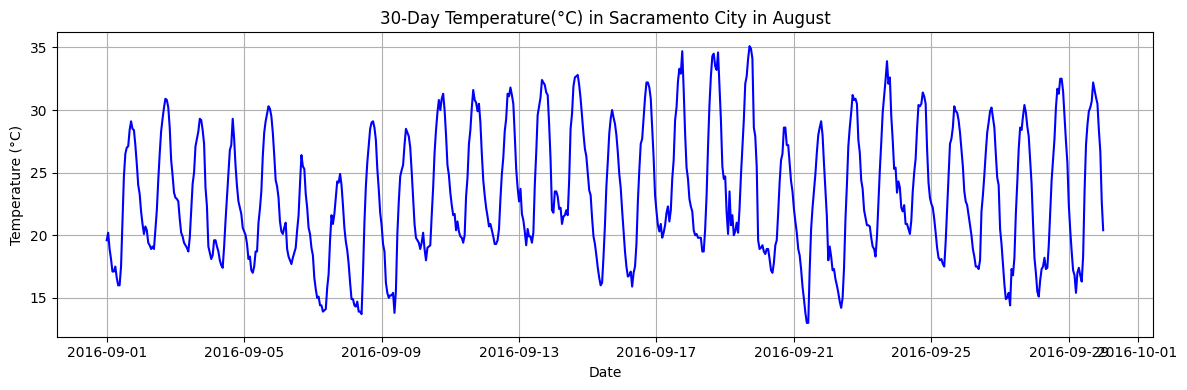

In [113]:
# Creating a time series plot of temperature
# Filter the DataFrame to include only dates from August 1 to the last day of August
august_data = chosen_city[(chosen_city['mdct'] >= '2016-09-01') & (chosen_city['mdct'] <= '2016-09-30')]

plt.figure(figsize=(12, 4))
plt.plot(august_data['mdct'], august_data['temp'], color='blue', linestyle='-')
plt.title('30-Day Temperature(°C) in Sacramento City in August')                             
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

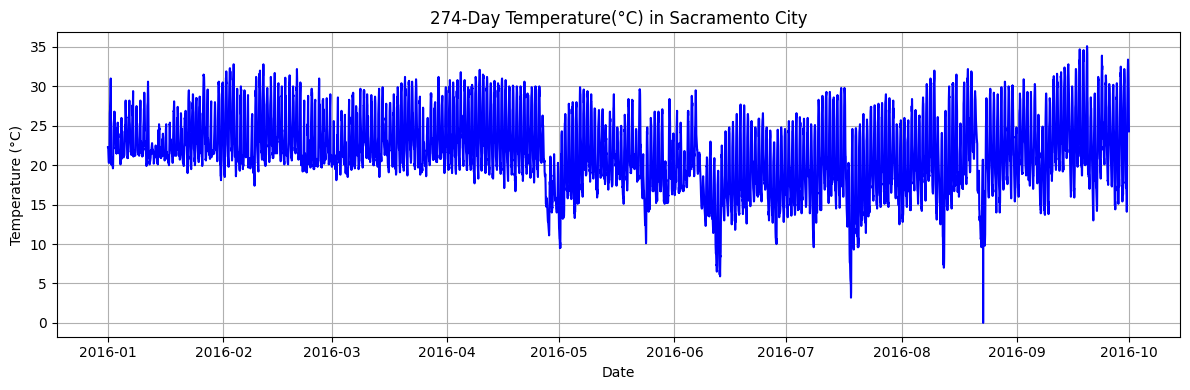

In [25]:
# Create a time series plot of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['temp'], color='blue', linestyle='-')
plt.title('274-Day Temperature(°C) in Sacramento City')                                   #274 days as the year 2016 is a leap year
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

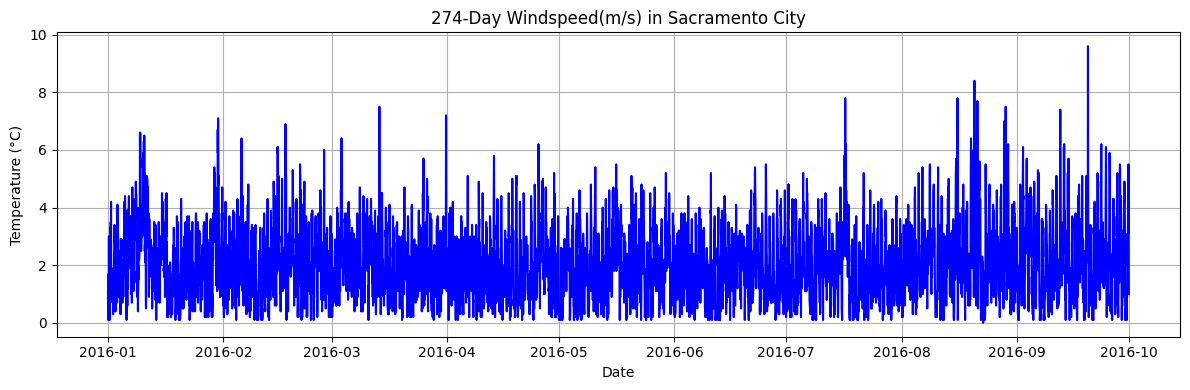

In [110]:
# Create a time series plot of temperature
plt.figure(figsize=(12, 4))
plt.plot(chosen_city['mdct'], chosen_city['wdsp'], color='blue', linestyle='-')
plt.title('274-Day Windspeed(m/s) in Sacramento City')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

## <span style="color:Orange;"> VI. ARIMA Model </span>  <a name="arima"></a>  
In this section, we'll build an ARIMA (AutoRegressive Integrated Moving Average) model to forecast temperature based on historical weather data. We'll start by preparing the data for modeling, then train the ARIMA model, and finally evaluate its performance. First, the group will find the best values for the ARIMA model by exploring different combinations in parameters (p, d, q).

In [82]:
p = d = q = range(0,2)

# Generating all different combinations of parameter
pdq = list(itertools.product(p, d, q))

# Generating all different combinations
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]

### Finding the best parameter
The group will use the Akaike Information Criterion value (AIC), which measures how well a model fits the data. The group finds the model that yields the lowest AIC value.

In [83]:
sacramento_temp = chosen_city[['mdct', 'temp']]
sacramento_temp.set_index('mdct', inplace=True)

In [44]:
sacramento_temp

,temp
mdct,
2016-01-01 00:00:00,22.3
2016-01-01 01:00:00,22.3
2016-01-01 02:00:00,22.1
2016-01-01 03:00:00,21.5
2016-01-01 04:00:00,20.8
...,...
2016-09-30 19:00:00,31.6
2016-09-30 20:00:00,31.2
2016-09-30 21:00:00,29.3


In [84]:
warnings.filterwarnings('ignore')     # remove the warnings

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=param, 
            seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)

            results = model.fit()
            print(f'ARIMA{param} * {param_seasonal}9 - AIC:{results.aic}')          # 9 since there are 9 months involved
        except:
            continue

ARIMA(0, 0, 0) * (0, 0, 0, 9)9 - AIC:59493.49768008627
ARIMA(0, 0, 0) * (0, 0, 1, 9)9 - AIC:52606.465761521205
ARIMA(0, 0, 0) * (0, 1, 0, 9)9 - AIC:44302.0444574341
ARIMA(0, 0, 0) * (0, 1, 1, 9)9 - AIC:38240.65893488921
ARIMA(0, 0, 0) * (1, 0, 0, 9)9 - AIC:44147.67445234129
ARIMA(0, 0, 0) * (1, 0, 1, 9)9 - AIC:38304.538554579936
ARIMA(0, 0, 0) * (1, 1, 0, 9)9 - AIC:40637.4779897821
ARIMA(0, 0, 0) * (1, 1, 1, 9)9 - AIC:37277.32148895976
ARIMA(0, 0, 1) * (0, 0, 0, 9)9 - AIC:50774.15739850007
ARIMA(0, 0, 1) * (0, 0, 1, 9)9 - AIC:45112.96479702018
ARIMA(0, 0, 1) * (0, 1, 0, 9)9 - AIC:37248.11106045674
ARIMA(0, 0, 1) * (0, 1, 1, 9)9 - AIC:31250.971255805245
ARIMA(0, 0, 1) * (1, 0, 0, 9)9 - AIC:37071.40300794167
ARIMA(0, 0, 1) * (1, 0, 1, 9)9 - AIC:31305.953868041044
ARIMA(0, 0, 1) * (1, 1, 0, 9)9 - AIC:33706.15716790526
ARIMA(0, 0, 1) * (1, 1, 1, 9)9 - AIC:30471.66923802066
ARIMA(0, 1, 0) * (0, 0, 0, 9)9 - AIC:23891.865630865766
ARIMA(0, 1, 0) * (0, 0, 1, 9)9 - AIC:23117.961132224664
ARIMA(

#### Fitting the model to data with the best parameters
The last AIC line has the lowest AIC value (22023.022) out of all the listed parameters. Thus, we will take `ARIMA(1, 1, 1), (1, 1, 1, 9)`

In [85]:
best_model = sm.tsa.statespace.SARIMAX(sacramento_temp, order=(1,1,1), seasonal_order=(1, 1, 1, 9),
                                       enforce_stationarity=False, enforce_invertibility=False)

results = best_model.fit()
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,0.6294,0.019,32.369,0.000,0.591,0.668
ma.L1,-0.2547,0.018,-13.833,0.000,-0.291,-0.219
ar.S.L9,-0.1402,0.011,-12.840,0.000,-0.162,-0.119
ma.S.L9,-1.0011,0.004,-249.245,0.000,-1.009,-0.993
sigma2,1.6659,0.012,143.990,0.000,1.643,1.689


Each weight of the models has a p-value (P>|z|) less than 0.05, that is why we'll retain the models.

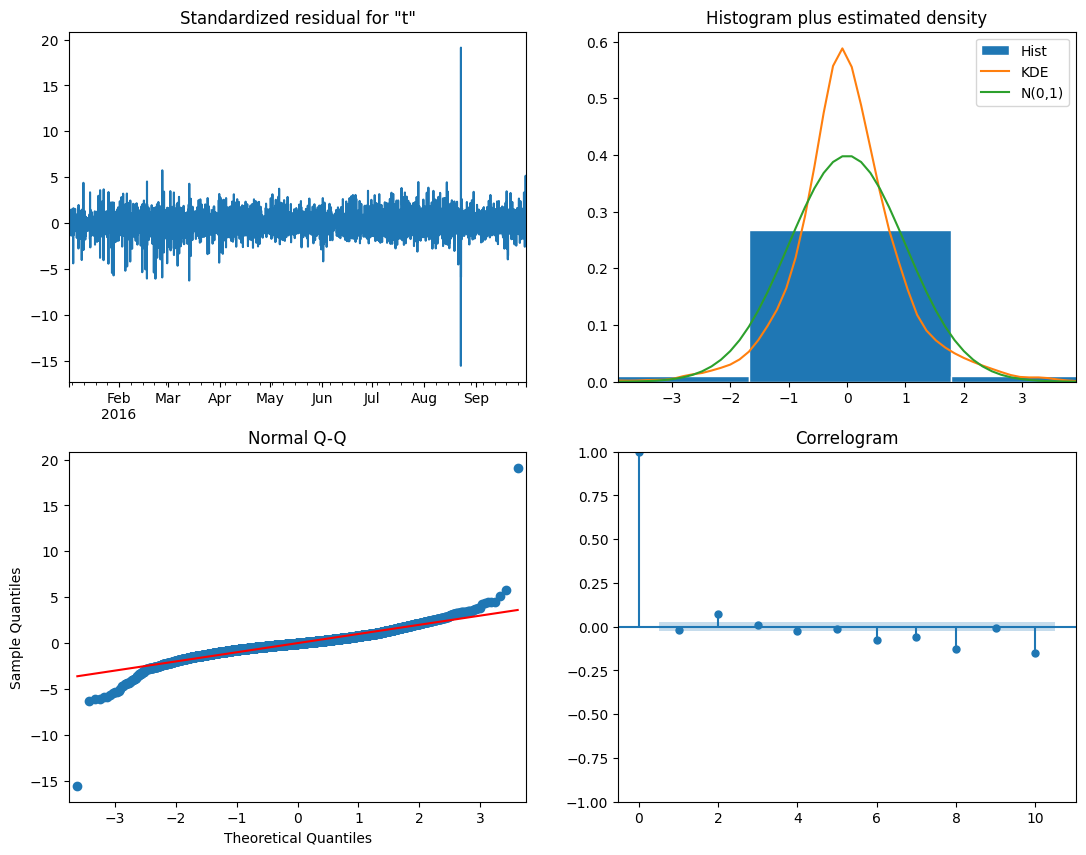

In [52]:
results.plot_diagnostics(figsize=(13, 10))
plt.show()

### Validating Forecast
First, we will determine the accuracy and errors of the actual and predicted values of a present data. Later on, the created model will be used to forecast the unknown data (since the dataset is only up until September 20, 2016). The created model will predict the temperature of the incoming 14 days starting from October 01, 2016.

In [89]:
# Confidence Interval of the dataset
pred = results.get_prediction(start=pd.to_datetime('2016-09-22 00:00:00'), dynamic=False)
pred_conf_i = pred.conf_int()
pred_conf_i

,lower temp,upper temp
2016-09-22 00:00:00,17.734896,22.801498
2016-09-22 01:00:00,13.742558,18.809160
2016-09-22 02:00:00,16.666615,21.733216
2016-09-22 03:00:00,15.339294,20.405896
2016-09-22 04:00:00,14.229782,19.296383
...,...,...
2016-09-30 19:00:00,29.835919,34.902428
2016-09-30 20:00:00,27.671428,32.737935
2016-09-30 21:00:00,28.115188,33.181695
2016-09-30 22:00:00,26.025403,31.091910


#### Actual vs Predicted Values
Predicting the values on the last 7 days of September. <span style="color:Red;"> temp </span> is the <span style="color:Red;">actual temperature </span>, while <span style="color:Blue;"> Pred_temp </span> is the <span style="color:Blue;">predicted temperature </span>. This step evaluates the mean squared error of the model.

In [90]:
y_forecasted = pred.predicted_mean
y_truth = sacramento_temp['2016-09-22 00:00:00':]
y_truth['Pred_temp'] = y_forecasted
y_truth

,temp,Pred_temp
mdct,,
2016-09-22 00:00:00,18.0,20.268197
2016-09-22 01:00:00,19.1,16.275859
2016-09-22 02:00:00,18.3,19.199916
2016-09-22 03:00:00,17.2,17.872595
2016-09-22 04:00:00,17.3,16.763083
...,...,...
2016-09-30 19:00:00,31.6,32.369174
2016-09-30 20:00:00,31.2,30.204682
2016-09-30 21:00:00,29.3,30.648442


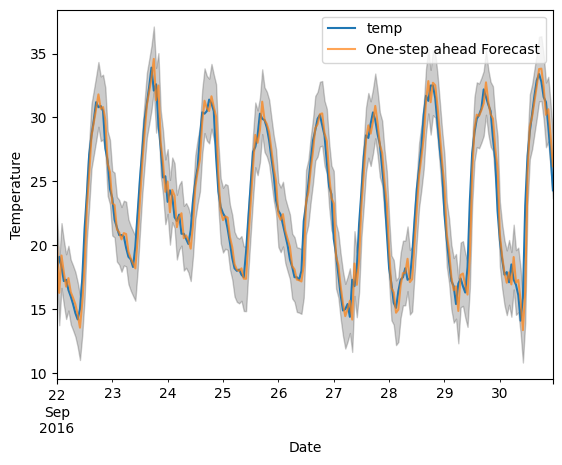

In [91]:
# Visualizing the forecast
ax = sacramento_temp['2016-09-22 00:00:00':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

#### Calculating Errors

In [63]:
mse = mean_squared_error(y_truth['temp'], y_truth['Pred_temp'])
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 1.83692662660533
Root Mean Squared Error: 1.3553326627088016


### Future Predictions

In [92]:
pred_future =  results.get_forecast(steps=336)        # Predicting 14 days ahead in the future
pred_conf_i = pred_future.conf_int()                  # Confidence interval of the forecasts

# Storing the predicted future values
future_df = pd.DataFrame(pred_future.predicted_mean)
future_df.columns = ['future_pred']

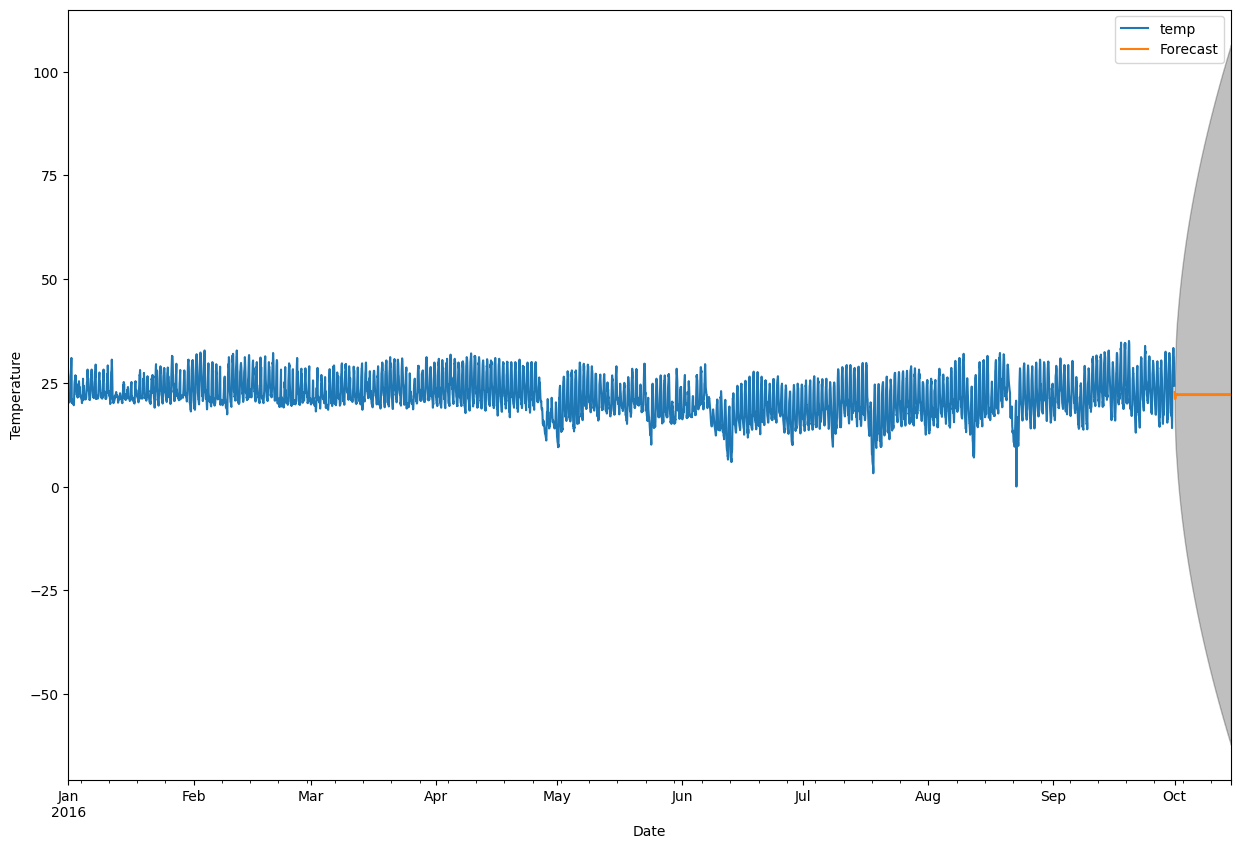

In [109]:
# Visualizing the predictions 7 days ahead
ax = sacramento_temp.plot(label='Observed', figsize=(15,10))
pred_future.predicted_mean.plot(ax=ax, label='Forecast')

ax.fill_between(pred_conf_i.index, pred_conf_i.iloc[:,0], pred_conf_i.iloc[:,1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
plt.legend()
plt.show()

## <span style="color:Orange;"> VII. Deep Learning Model </span>  <a name="dl"></a>  
We implement deep learning models for temperature prediction and compare their performance with the ARIMA model. We'll also include a comparison between the results of the ARIMA model and deep learning models, assessing which model performs better in prediction.

In [117]:
# Select relevant columns for modeling
columns = ['temp', 'prcp', 'stp', 'gbrd', 'hmdy', 'wdsp']
chosen_city = chosen_city[columns].copy()

# Normalize features
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(chosen_city)

In [118]:
# Sequence length and features
time_step = 24                             # Predicting after 24 hours/a day
num_features = len(features)

In [119]:
X = []
y = []

for i in range(len(scaled_df) - time_step):
    seq = scaled_df[i:i+time_step]
    label = scaled_df[i+time_step][0]   # temp column
    X.append(seq)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [120]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (556, 24, 6)
Shape of X_test: (140, 24, 6)
Shape of y_train: (556,)
Shape of y_test: (140,)


In [158]:
# Creating the LSTM Model
model = tf.keras.models.Sequential([tf.keras.layers.LSTM(units=128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.LSTM(units=64, return_sequences=True),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.LSTM(units=32, return_sequences=False),
                                   tf.keras.layers.Dropout(0.2),

                                   tf.keras.layers.Dense(units=1)
])

c:\Users\User\anaconda3\envs\NEW_ENV_NAME\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [159]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 24, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 24, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,977 (511.63 KB)

 Trainable params: 130,977 (511.63 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs = 100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 174ms/step - accuracy: 0.0010 - loss: 0.1902 - val_accuracy: 0.0089 - val_loss: 0.0511
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.0023 - loss: 0.0669 - val_accuracy: 0.0089 - val_loss: 0.0391
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.0033 - loss: 0.0503 - val_accuracy: 0.0089 - val_loss: 0.0238
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0037 - loss: 0.0333 - val_accuracy: 0.0089 - val_loss: 0.0152
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0069 - loss: 0.0264 - val_accuracy: 0.0089 - val_loss: 0.0110
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.0052 - loss: 0.0187 - val_accuracy: 0.0089 - val_loss: 0.0084
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.0020 - loss: 0.0158 - val_accuracy: 0.0089 - val_loss: 0.0084
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.0015 - loss: 0.0134 - val_accuracy: 

In [152]:
test_loss = model.evaluate(X_test, y_test)
print("Test loss: ", test_loss)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0000e+00 - loss: 0.0065
Test loss:  [0.006526497658342123, 0.0]


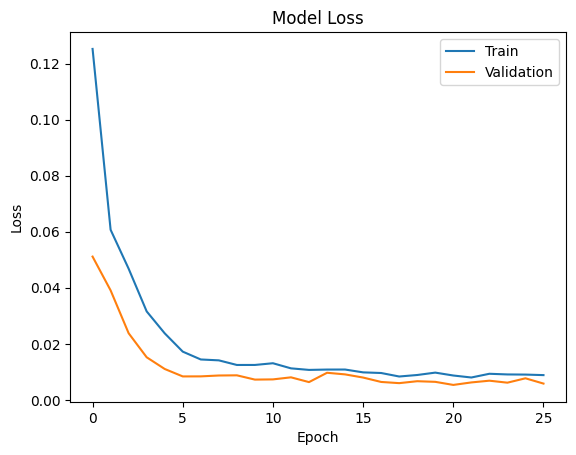

In [161]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

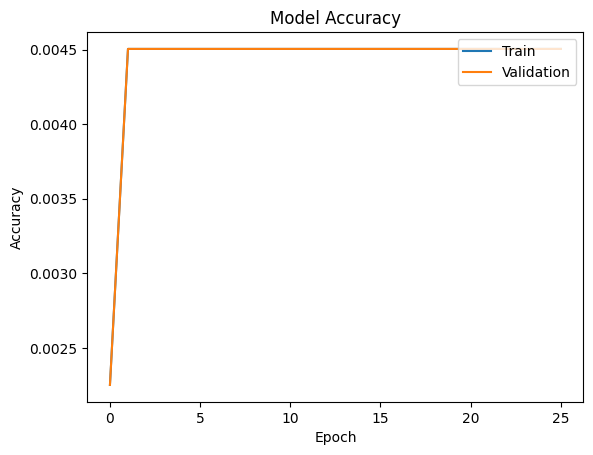

In [162]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [164]:
predictions = model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Absolute Error: ", mae)
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step


NameError: name 'mean_absolute_error' is not defined

In [ ]:
test_y_copy = np.repeat(test_y.reshape(-1,1), test_x.shape[-1], axis=-1)
true_temp = scaler.inverse_transform(test_y_copy)[:,0]

prediction = best_model.predict(test_X)
prediction_copy = np.repeat(prediction, 9, axis=-1)
predicted_temp = scaler.inverse_transform(prediction_copy)[:,0]

## <span style="color:Orange;"> VIII. Comparison </span>  <a name="comparison"></a>  
<i> Comparison between the results of the two specified models: ARIMA and Deep Learning Models, and assessing which model performs better in <b> Predicting and Classification </b> </i>  



## <span style="color:Orange;"> IX. Conclusion and Recommendation </span> <a name="conclusion"></a>  
`edit contents`